In [1]:
import tensorflow as tf
import tensorflow.compat.v1 as tfc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import matthews_corrcoef

In [2]:
tf.keras.backend.clear_session()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
try: sess.close() 
except: pass

tfc.enable_eager_execution()
print(f"eagely execution: {tf.executing_eagerly()}")

gpu_options= tfc.GPUOptions(per_process_gpu_memory_fraction = 0.8)
sess = tfc.InteractiveSession(config=tfc.ConfigProto(gpu_options=gpu_options))

Num GPUs Available:  1
Found GPU at: /device:GPU:0
eagely execution: True


## Constants

In [3]:
CHANNELS = 1
INPUT_SHAPE = [218,145,CHANNELS]

BATCH_SIZE = 64

SOURCE = "train_images/"
RES = f"train_images_res_{INPUT_SHAPE[0]}x{INPUT_SHAPE[1]}/"

MODELS = ["stefan_final_oversampeling_lr01", "stefan_final_class-weights_lr01",
         "oliver_final_oversampeling_lr01", "oliver_final_class-weights_lr01",
         "didi_final_oversampeling_lr01-2", "didi_final_class-weights_lr01"]
#MODELS = ["didi_final_oversampeling_lr01-2"]

In [4]:
thresh = 200
max_instances = None

def undersample(df, index, max_instances):
    if max_instances is not None:
        sampled = df[df.species == index].sample(n=max_instances, random_state=101) if len(df[df.species == index]) > max_instances else df[df.species == index]
    else:
        sampled = df[df.species == index]
    return  sampled

train_csv = "train.csv"
train_df = pd.read_csv(train_csv)
train_df.species.replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)


#train_df.species = train_df.species.apply(lambda x: 'other_dolphin' if ('dolphin' in x and not "bottlenose" in x) else x)
species_counts = train_df['species'].value_counts()


final_species = species_counts[species_counts > thresh].index.tolist()
mask = train_df.species.apply(lambda x: any(item for item in final_species if item in x))
final_df = train_df[mask]

dfs = []
for species in final_species:
    dfs.append(undersample(final_df,species,max_instances))

final_train_df = pd.concat(dfs,axis=0).sort_index()
final_train_df["species"].value_counts()

train_df=final_train_df
names = list(train_df.species.unique())

## Input Pipeline

In [5]:
@tf.function
def process_tuple(image,label):
    img = tf.io.read_file(image)
    img = tf.image.decode_jpeg(img, channels=CHANNELS)
    img = tf.image.random_contrast(img, 0.1, 0.5, seed=None)
    img = tf.image.convert_image_dtype(img, tf.float16)
    return img,label

In [6]:
test_even_df = pd.read_pickle("test_ds.pickle")
print(len(test_even_df))
n = len(test_even_df)

5069


In [7]:
test_label = list(test_even_df["species"].values)
test_img = list(map(RES.__add__,test_even_df["image"]))
test_ds = tf.data.Dataset.from_tensor_slices((test_img,test_label)).map(process_tuple,num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)

In [8]:
test_batched = test_ds.batch(batch_size=BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

## Evaluate models

In [11]:
def make_conf_matrix(y_act,y_pred,model):
    cm=confusion_matrix(y_act,y_pred)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100

    plt.figure(figsize=(17, 17))

    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
            else:
                annot[i, j] = '%d' % (c)
    cm=confusion_matrix(y_act,y_pred,normalize='true')            
    cm = pd.DataFrame(cm, index=names, columns=names)

    ax = sns.heatmap(cm, annot=annot, fmt='', cbar=True, cmap="Blues")

    ax.set_xlabel('\nPredicted Species')
    ax.set_ylabel('Actual Species')

    ax.xaxis.set_ticklabels(names,rotation = 90)
    ax.yaxis.set_ticklabels(names, rotation = 360)

    plt.savefig(f"eval/{model}_CM", bbox_inches = "tight")

In [12]:
def make_class_report(y_act,y_pred,model):
    rep = classification_report(y_act, y_pred,target_names=names ,output_dict=True)
    
    plt.figure(figsize=(10, 10))
    
    ax = sns.heatmap(pd.DataFrame(rep).iloc[:-1, :].T, annot=True, cmap="rocket_r")
    plt.savefig(f"eval/{model}_CR", bbox_inches = "tight")

80/80 [==============================] - 15s 138ms/step


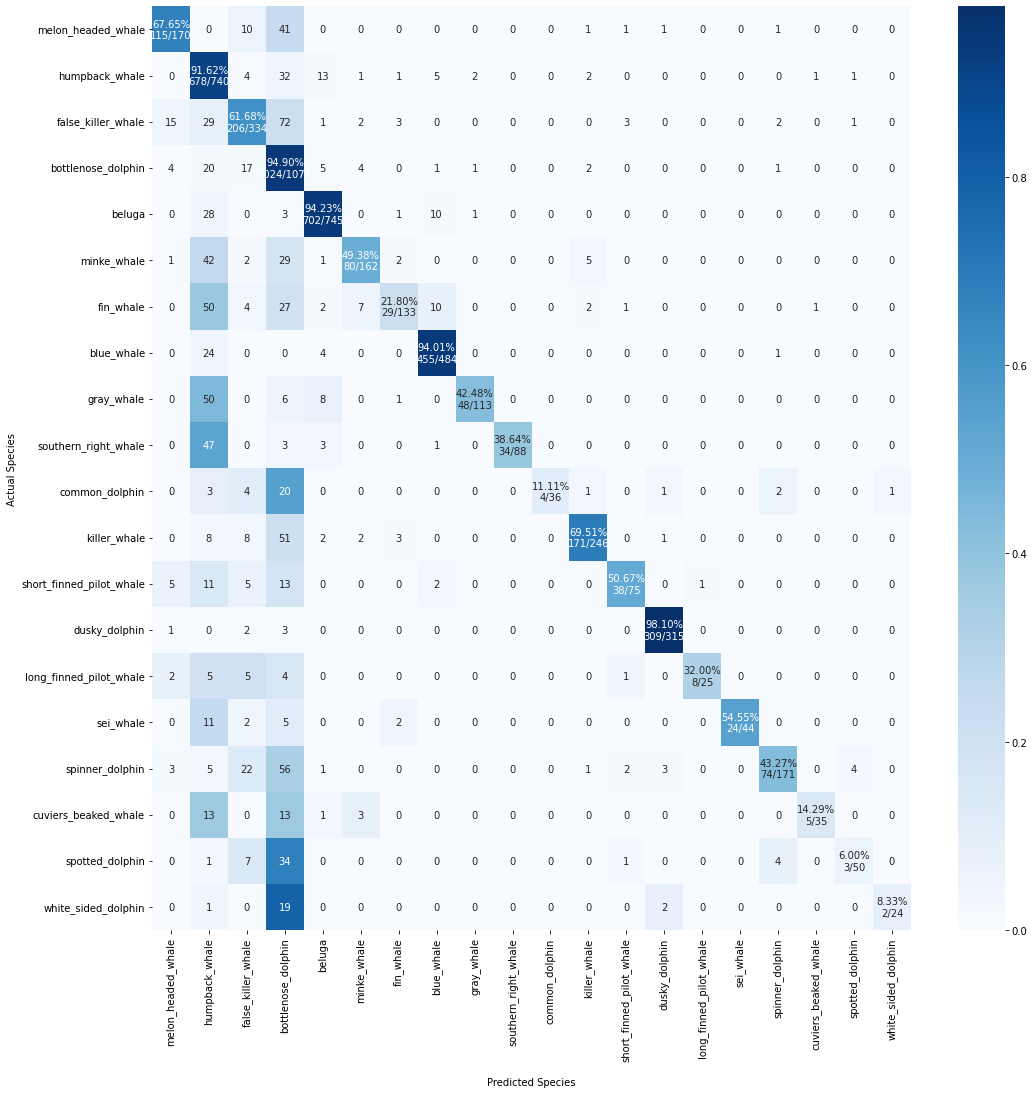

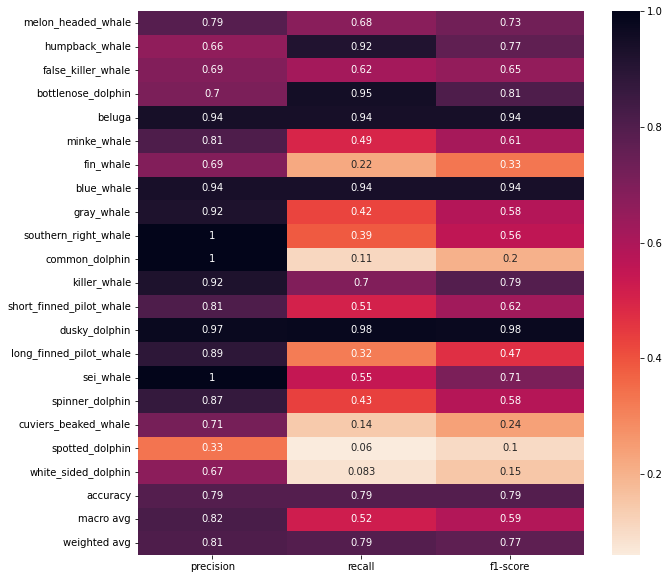

In [13]:
y_act = np.array(test_label)

metrics = []
for model in MODELS:
    cm = keras.models.load_model(model)
    pr = cm.predict(test_batched)
    
    y_pred = pr.argmax(axis=1)
    make_conf_matrix(y_act,y_pred,model)
    make_class_report(y_act,y_pred,model)

In [20]:
for model in MODELS:
    cm = keras.models.load_model(model)
    cval = cm.evaluate(test_batched, verbose = 0)
    print(f"{model} test loss, test acc: {cval}, test eror-rate: {round((1-cval[1])*100,2)}")

didi_final_oversampeling_lr01-2 test loss, test acc: [0.9282059073448181, 0.792464017868042], test eror-rate: 20.75


In [15]:
y_act = np.array(test_label)
for model in MODELS:
    cm = keras.models.load_model(model)
    pr = cm.predict(test_batched)
    y_pred = pr.argmax(axis=1)
    
    
    cks = matthews_corrcoef(y_act,y_pred)
    print(f"{model}: {cks}")

80/80 [==============================] - 7s 88ms/step
didi_final_oversampeling_lr01-2: 0.7633926507492577


In [27]:
s = int(n/5)-1
dss = [test_ds.take(s),
       test_ds.skip(s).take(s),
       test_ds.skip(s).skip(s).take(s),
       test_ds.skip(s).skip(s).skip(s).take(s),
       test_ds.skip(s).skip(s).skip(s).skip(s).take(s)
]

    

m_vals = []
for model in MODELS:
    cm = keras.models.load_model(model)
    vals = []
    for i,ds in enumerate(dss):
        d = ds.batch(batch_size=BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
        
        pr = cm.predict(d)
        cval = cm.evaluate(d, verbose = 0)
        
        y_pred = pr.argmax(axis=1)
        y_act = np.array(test_label[s*i:s*i+s])
        
        ter = round((1-cval[1])*100,2)
        mcc = matthews_corrcoef(y_act,y_pred)
        vals.append([cval[0],cval[1],ter,mcc])
    m_vals.append(vals)

16/16 [==============================] - 3s 90ms/step


In [59]:
loss = []
acc = []
ter = []
mcc = []
for vals in m_vals:
    vals = np.array(vals)
    loss.append([np.mean(vals[:,0]),np.std(vals[:,0])])
    acc.append([np.mean(vals[:,1]),np.std(vals[:,1])])
    ter.append([np.mean(vals[:,2]),np.std(vals[:,2])])
    mcc.append([np.mean(vals[:,3]),np.std(vals[:,3])])

In [60]:
labels = MODELS

loss_std = np.array(loss)[:,1]
loss = np.array(loss)[:,0]

acc_std = np.array(acc)[:,1]
acc = np.array(acc)[:,0]

ter_std = np.array(ter)[:,1]
ter = np.array(ter)[:,0]

mcc_std = np.array(mcc)[:,1]
mcc = np.array(mcc)[:,0]

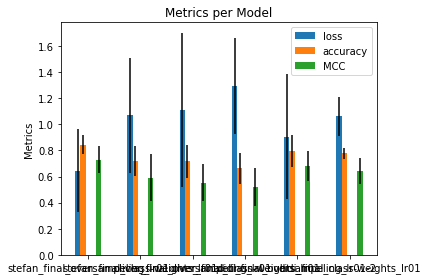

In [63]:
x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width*2, loss, width,yerr=loss_std, label='loss')
rects2 = ax.bar(x - width, acc, width,yerr=acc_std, label='accuracy')
#rects2 = ax.bar(x + width, ter, width,yerr=ter_std, label='test-error-rate')
rects2 = ax.bar(x + width*2, mcc, width,yerr=mcc_std, label='MCC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Metrics')
ax.set_title('Metrics per Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()

plt.show()

80/80 [==============================] - 7s 90ms/step


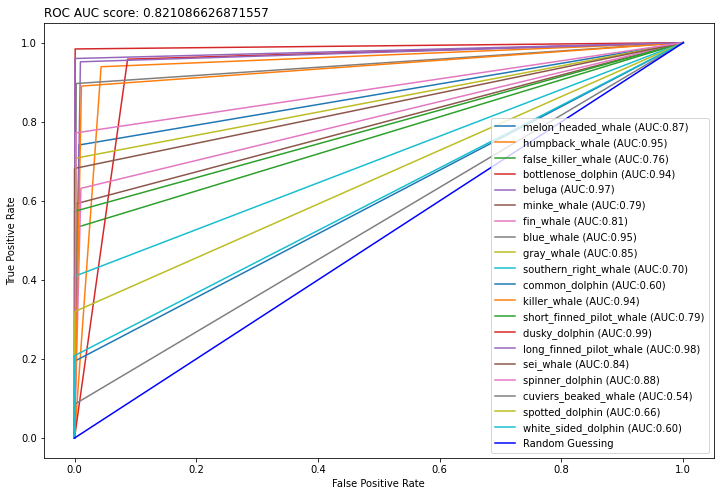

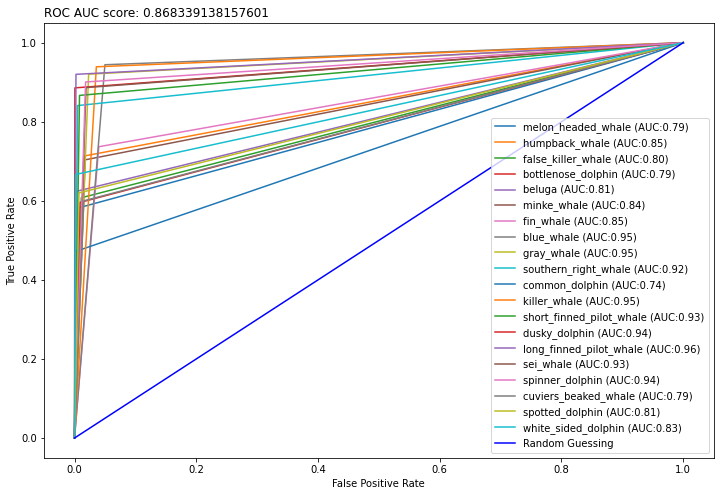

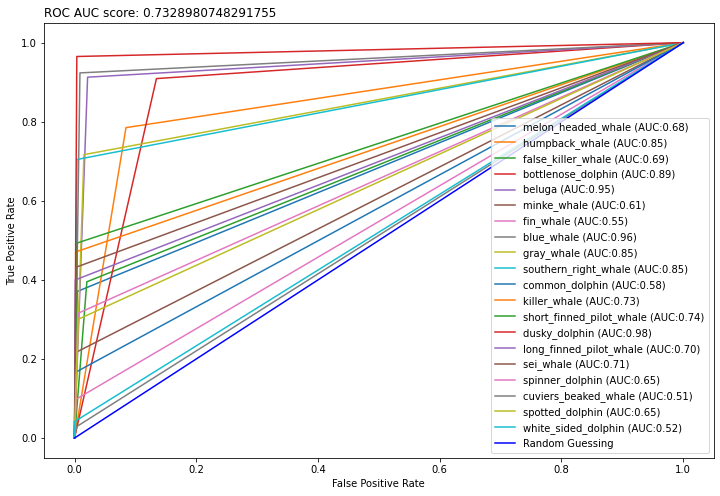

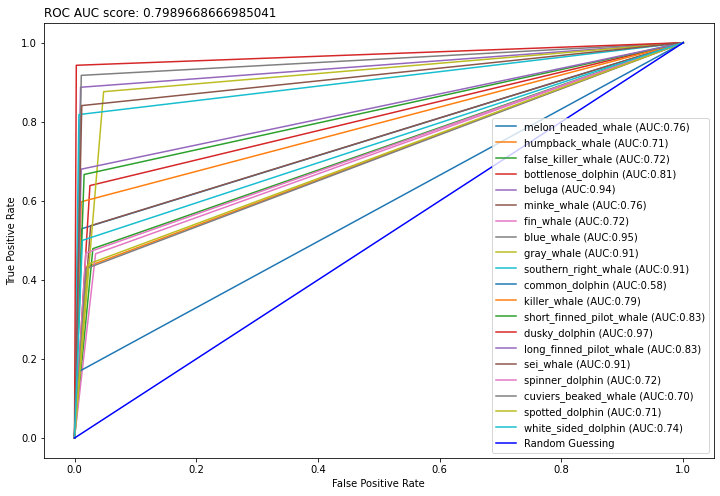

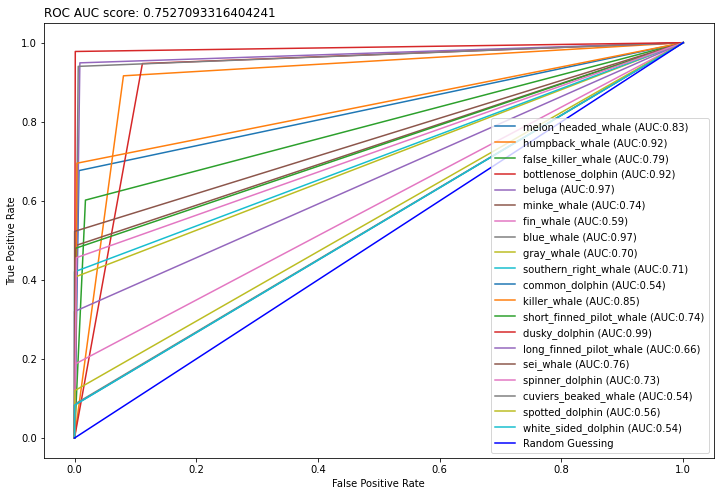

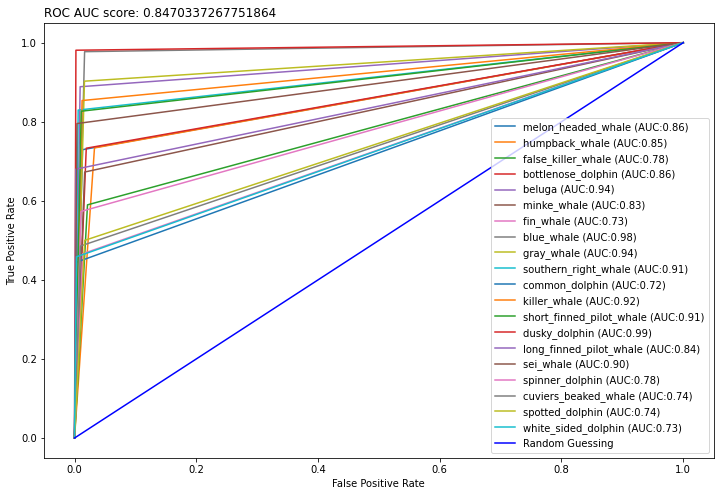

In [15]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= names
y_act = np.array(test_label)


def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    
    score = roc_auc_score(y_test, y_pred, average=average)
    c_ax.legend()
    plt.title(f"ROC AUC score: {score}", loc='left')
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')


for model in MODELS:
    fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
    
    cm = keras.models.load_model(model)
    pr = cm.predict(test_batched)
    y_pred = pr.argmax(axis=1)
    multiclass_roc_auc_score(y_act, y_pred)

    plt.savefig(f"eval/{model}_ROC", bbox_inches = "tight")

In [22]:
nnnn= ["oliver", "didi", "stefan"]

for n in nnnn:
    st = f"""
    \\begin{{center}}
    \\begin{{tabular}}{{|l|l|}}
    \hline
    \\rowcolor[HTML]{{EFEFEF}} 
    \\textbf{{class-weights}} & \\textbf{{oversampeling}} \\\ \hline
    \includegraphics[scale = 0.2]{{images/eval_img/{n}_final_class-weights_lr01_CM.png}}                        & \includegraphics[scale = 0.2]{{images/eval_img/{n}_final_oversampeling_lr01_CM.png}}                 \\\ \hline
    \includegraphics[scale = 0.3]{{images/eval_img/{n}_final_class-weights_lr01_CR.png}}                       & \includegraphics[scale = 0.3]{{images/eval_img/{n}_final_oversampeling_lr01_CR.png}}                   \\\ \hline
    \includegraphics[scale = 0.25]{{images/eval_img/ROC/{n}_final_class-weights_lr01_ROC.png}}                    & \includegraphics[scale = 0.25]{{images/eval_img/ROC/{n}_final_oversampeling_lr01_ROC.png}}                  \\\ \hline
    \end{{tabular}}
    \end{{center}}
    """
    print(st)


    \begin{center}
    \begin{tabular}{|l|l|}
    \hline
    \rowcolor[HTML]{EFEFEF} 
    \textbf{class-weights} & \textbf{oversampeling} \\ \hline
    \includegraphics[scale = 0.2]{images/eval_img/oliver_final_class-weights_lr01_CM.png}                        & \includegraphics[scale = 0.2]{images/eval_img/oliver_final_oversampeling_lr01_CM.png}                 \\ \hline
    \includegraphics[scale = 0.3]{images/eval_img/oliver_final_class-weights_lr01_CR.png}                       & \includegraphics[scale = 0.3]{images/eval_img/oliver_final_oversampeling_lr01_CR.png}                   \\ \hline
    \includegraphics[scale = 0.25]{images/eval_img/ROC/oliver_final_class-weights_lr01_ROC.png}                    & \includegraphics[scale = 0.25]{images/eval_img/ROC/oliver_final_oversampeling_lr01_ROC.png}                  \\ \hline
    \end{tabular}
    \end{center}
    

    \begin{center}
    \begin{tabular}{|l|l|}
    \hline
    \rowcolor[HTML]{EFEFEF} 
    \textbf{class-weights} & \tex